# Exploračná analýza dat

### Popis Notebooku
* Nasledujúci notebook vznikol ako domáci projekt pre zimný predmet **Vizualizace dát (2023)** na ČVUT.     
* Obsahuje exploračnú analýzu datasetu [cestovních řádů](https://pid.cz/o-systemu/opendata/#h-gtfs) Pražskej Integrovanej dopravy.

* Notebook je zložený z 3 častí
    1. Príprava a predspracovanie dát
    2. Základná analýza siete
        * grafová reprezentácia siete
        * analýza zastávok pomocou mier centralít
    3. Vizualizácia odpovedí na rôzne otázky pomocou dát.

# 1. Predspracovanie dát
- Dátovú analýzu a vizualizáciu začneme získaním základných informácii o datasetoch:
     1. **D**
     2. **stops**

Načítanie potrebných knižníc:

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
from collections import Counter

Načítanie datasetov:

In [2]:
pid = pd.read_csv('d.csv')
stops = pd.read_csv('stops.txt')

Zístíme základné vlastnosti datasetu **pid** (konkrétne počet záznamov, počet a význam príznakov, počet chýbajúcich hodnôt).

In [3]:
pid.head()

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


In [4]:
pid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


In [5]:
def print_unique(data):
    """ Analyze the unique values of each column """  
    for column in data.columns:
        print(column)
        print(f'Number of unique vals: {data[column].nunique()}')
        print(f'Unique Values: {data[column].unique()}')
        print('-' * 30)

In [6]:
print_unique(pid)

stop_from
Number of unique vals: 15178
Unique Values: ['U2991Z301' 'T58005' 'U4610Z301' ... 'U106Z102P' 'U1853Z3' 'U1714Z2']
------------------------------
stop_from_name
Number of unique vals: 7389
Unique Values: ['Hněvice' 'Hněvice seř.n.' 'Záluží' ... 'U Mlejna' 'Můstek' 'Lužiny']
------------------------------
stop_to
Number of unique vals: 15154
Unique Values: ['T58005' 'U4610Z301' 'U4609Z301' ... 'U106Z102P' 'U286Z102P' 'U1853Z3']
------------------------------
stop_to_name
Number of unique vals: 7387
Unique Values: ['Hněvice seř.n.' 'Záluží' 'Dobříň' ... 'U Mlejna' 'Můstek' 'Lužiny']
------------------------------
depart_from
Number of unique vals: 14021
Unique Values: ['4:53:00' '4:54:30' '4:56:00' ... '27:47:20' '28:35:20' '29:05:20']
------------------------------
arrive_to
Number of unique vals: 13858
Unique Values: ['4:54:30' '4:56:00' '4:59:00' ... '27:47:20' '28:35:20' '29:05:20']
------------------------------
route_type
Number of unique vals: 6
Unique Values: [2 3 0 4 7

- dataset obsahuje 1642433 záznamov a 15 príznakov
- neobsahuje žiadne chýbajúce hodnoty
- dni, v ktorých spoje premávajú, sú reprezentované pomocou one-hot encoding príznakmi `monday` až `sunday`
- `route_type` určuje typ dopravného prostriedku (električky - 0, metro - 1, želenice - 2, autobusy - 3, Přívozy - 4, Lanová dráha - 7)
- `is_night` určuje nočné spoje
- `arrive_to` a `depart_from` reprezentujú čas príchodu/odchodu na zastávku
    - zo zadania vieme, že môžu obsahovať hodnoty > 23:59:59
    - zároveň je potrebné ich prekonvertovať na časový typ 

In [7]:
def fix_n(num, max = 60):
    """Normalize number value"""
    # return zero-padded number
    return str(int(num) % max).zfill(2)

def to_date(data):
    """Transfrom string to datetime format"""
    hour, minute, second = data.split(':')
    hour = fix_n(hour, 24)
    minute = fix_n(minute)
    second = fix_n(second)
    return f'{hour}:{minute}:{second}'

In [8]:
pid['depart_from'] = pid['depart_from'].apply(to_date)
pid['arrive_to'] = pid['arrive_to'].apply(to_date)

In [9]:
pid['depart_from'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1642433 entries, 0 to 1642432
Series name: depart_from
Non-Null Count    Dtype 
--------------    ----- 
1642433 non-null  object
dtypes: object(1)
memory usage: 12.5+ MB


In [10]:
print(f"depart_from - max: {pid['depart_from'].max()}, mix: {pid['depart_from'].min()}")
print(f"depart_from - max: {pid['arrive_to'].max()}, mix: {pid['arrive_to'].min()}")

depart_from - max: 23:59:50, mix: 00:00:00
depart_from - max: 23:59:55, mix: 00:00:00


In [11]:
pid['depart_from'] = pd.to_datetime(pid['depart_from'], format='%H:%M:%S')
pid['arrive_to'] = pd.to_datetime(pid['arrive_to'], format='%H:%M:%S')
pid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   stop_from       1642433 non-null  object        
 1   stop_from_name  1642433 non-null  object        
 2   stop_to         1642433 non-null  object        
 3   stop_to_name    1642433 non-null  object        
 4   depart_from     1642433 non-null  datetime64[ns]
 5   arrive_to       1642433 non-null  datetime64[ns]
 6   route_type      1642433 non-null  int64         
 7   is_night        1642433 non-null  int64         
 8   monday          1642433 non-null  int64         
 9   tuesday         1642433 non-null  int64         
 10  wednesday       1642433 non-null  int64         
 11  thursday        1642433 non-null  int64         
 12  friday          1642433 non-null  int64         
 13  saturday        1642433 non-null  int64         
 14  sunday          16

Príznaky `depart_from` a `arrive_to` majú správny rozsah a sú reprezentované typom *datetime*.

Dataset **pid** považujeme za spracovaný.

Rovnako budeme postupovať aj pri datasete **stops**.

In [12]:
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,level_id,platform_code,asw_node_id,asw_stop_id
0,U50S1,Budějovická,50.044411,14.448787,P,NaN,1,NaN,1,NaN,NaN,50.0,NaN
1,U52S1,Chodov,50.031672,14.490961,P,NaN,1,NaN,1,NaN,NaN,52.0,NaN
2,U75S1,Kolbenova,50.110395,14.516398,P,NaN,1,NaN,1,NaN,NaN,75.0,NaN
3,U78S1,Ládví,50.126591,14.469451,P,NaN,1,NaN,1,NaN,NaN,78.0,NaN
4,U100S1,Vltavská,50.100298,14.438492,P,NaN,1,NaN,1,NaN,NaN,100.0,NaN


In [13]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              16435 non-null  object 
 1   stop_name            15936 non-null  object 
 2   stop_lat             16435 non-null  float64
 3   stop_lon             16435 non-null  float64
 4   zone_id              15408 non-null  object 
 5   stop_url             0 non-null      float64
 6   location_type        16435 non-null  int64  
 7   parent_station       954 non-null    object 
 8   wheelchair_boarding  16435 non-null  int64  
 9   level_id             954 non-null    object 
 10  platform_code        14750 non-null  object 
 11  asw_node_id          15748 non-null  float64
 12  asw_stop_id          15354 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.6+ MB


Dataset obsahuje 16435 záznamov a 12 príznakov.

Keďže z datasetu **stops** budeme využívať len informácie o pozíciach zastávok, dataset nebudeme spracovávať. 

In [14]:
stops['stop_name'].nunique()

7547

Predchádzajúca bunka ukazuje, že k jednotlivým staniciam sú priradené viaceré lokácie. Keďže najčastejšie pôjde o rôzne vchody alebo zastávky pre rôzne dopravné prostriedky, výslednú lokáciu zastávky určíme pomocou priemeru.

In [15]:
def get_avg_loc(data, stop_name, new_stop):
    """Calculate average location of a station"""
    all_locations = data[data['stop_name'] == stop_name][['stop_lat', 'stop_lon']]
    new_stop[stop_name] = [all_locations['stop_lat'].mean(), all_locations['stop_lon'].mean()][::-1]

avg_stops_loc = {}
for i in stops['stop_name'].unique():
    get_avg_loc(stops, i, avg_stops_loc)

# 2. Vizualizácia siete
Dopravnú sieť budeme vizualizovať pomocou knižnice networkx. Každá zastávka bude predstavovať jeden vrchol. Medzi vrcholmi sa bude nachádzať orientovaná hrana práve vtedy, keď medzi zastávkami premáva nejaký spoj. Váha hrany reprezentuje počet výskytov zastávok v datasete ***pid***, teda počet dopravných prostriedkov, ktoré medzi zastávkami prejdú za jeden deň. 

Vizualizovať budeme električkovú sieť -> `route_type` = 0.

Vytvoríme graf so zastávkami ako vrcholmi:

In [16]:
route_type = 0 # trams

# Retreive only the tram routes
tram_stops = pid[pid['route_type'] == route_type]

# Populate a directed graph with tram stops 
network = nx.DiGraph()
network.add_nodes_from(tram_stops['stop_to_name'].unique(), type='stop')

Vytvoríme hrany s váhou:

In [17]:
# inspired by https://stackoverflow.com/questions/44992103/how-to-create-an-edge-list-from-pandas-dataframe and chatGPT
edges = list(pid[(pid['route_type'] == route_type)][['stop_from_name', 'stop_to_name']].itertuples(index=False, name=None))
counts = Counter(edges)
w_edges = [(key, value, count) for (key, value), count in counts.items()]

In [18]:
network.add_weighted_edges_from(w_edges)

Vizualizujeme sieť:

In [19]:
def add_offset(labels, stop, x, y):
    """add offset to labels"""
    labels[stop] = [labels[stop][0] + x, labels[stop][1] + y]

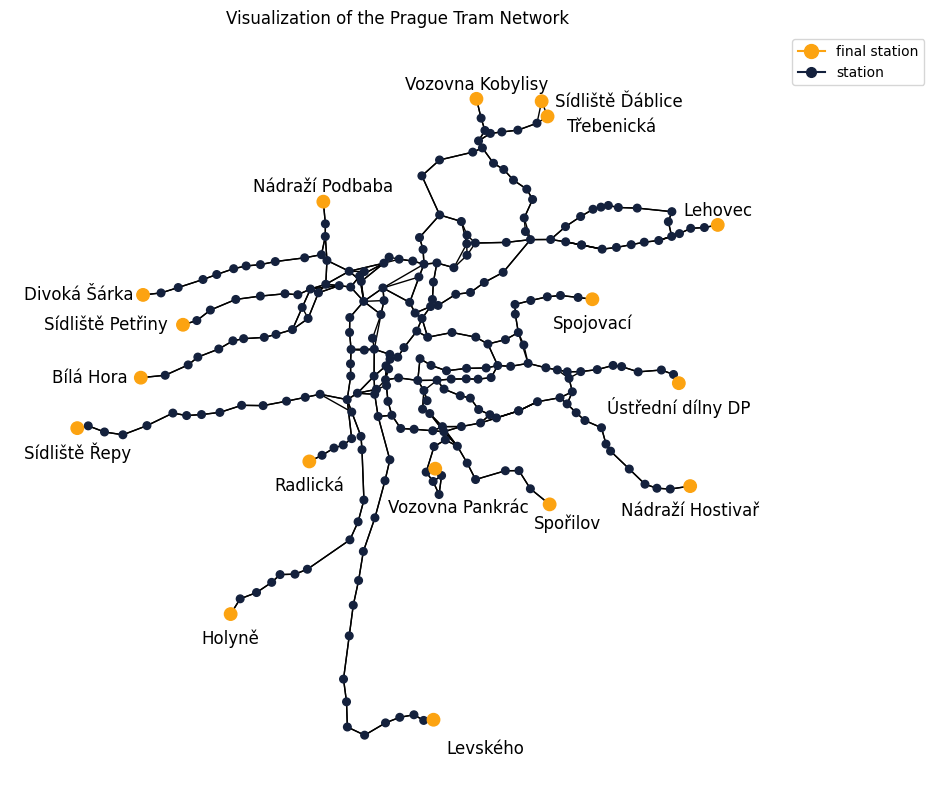

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Visualization of the Prague Tram Network')
ax.spines[:].set_visible(False)
# inspired by: https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling
labels={node:node for node in network if network.in_degree[node] <= 1 and network.out_degree[node] <= 1}
labels_pos = avg_stops_loc.copy()

# Delete labels to increase readibility of the graph 
del labels['Zvonařka']
del labels['Korunovační']
del labels['Karlovy lázně']
del labels['Mezi Hřbitovy']
del labels['Divadlo pod Palmovkou']


# Add offset
add_offset(labels_pos, 'Vozovna Kobylisy', 0, 0.003)
add_offset(labels_pos, 'Nádraží Podbaba', 0, 0.003)
add_offset(labels_pos, 'Lehovec', 0, 0.003)
add_offset(labels_pos, 'Divoká Šárka', -0.025, 0)
add_offset(labels_pos, 'Bílá Hora', -0.02, 0)
add_offset(labels_pos, 'Sídliště Petřiny', -0.03, 0)
add_offset(labels_pos, 'Sídliště Řepy', 0, -0.005)
add_offset(labels_pos, 'Radlická', 0, -0.005)
add_offset(labels_pos, 'Holyně', 0, -0.005)
add_offset(labels_pos, 'Spojovací', 0, -0.005)
add_offset(labels_pos, 'Ústřední dílny DP', 0, -0.005)
add_offset(labels_pos, 'Nádraží Hostivař', 0, -0.005)
add_offset(labels_pos, 'Spořilov', 0.007, -0.004)
add_offset(labels_pos, 'Vozovna Pankrác', 0.009, -0.008)
add_offset(labels_pos, 'Levského', 0.02, -0.006)
add_offset(labels_pos, 'Třebenická', 0.025, -0.002)
add_offset(labels_pos, 'Sídliště Ďáblice', 0.03, 0)


# Create Legend
legend_labels = {'final station': ['#fca311', 10], 'station': ['#14213d', 7]}
legend_handles = [plt.Line2D([0], [0], marker='o', color=data[0], markersize=data[1]) for label, data in legend_labels.items()]

# Draw graph
ax.legend(legend_handles, legend_labels.keys(), loc='upper left', bbox_to_anchor=(1, 1))
nx.draw_networkx_labels(network, labels = labels, pos=labels_pos, ax = ax)
edge_weights = nx.get_edge_attributes(network, 'weight')
nx.draw_networkx_edges(network, pos=avg_stops_loc, arrows=False, ax=ax)
nx.draw_networkx_nodes(network, pos=avg_stops_loc, node_size=[80 if node in labels else 30 for node in network],
                       node_color=['#fca311' if node in labels else '#14213d' for node in network], ax=ax)

## 2.1 Analýza mier centralít
Porovnáme sieť počas pracovného týždňa a víkendu. Na vykresľovanie budeme používať nižšie definované funkcie:
- vis_centrality - vykreslí graf, v ktorom farba vrcholov bude reprezentovať ich hodnotu centrality
- bar_centrality - vykreslí stĺpcový graf prvých n vrcholov s najvyššou hodnotou centrality

In [21]:
def vis_centrality(subgraph, values, title_network, title_bar_char, labels, labels_pos, stops_loc):
    """Visulize the centrality values on subgraph"""
    #inspired by https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html
    fig, ax = plt.subplots(figsize=(13, 10))
    ax.grid(False)
    ax.set_title(title_network)
    ax.spines[:].set_visible(False)
    
    # plot network
    nx.draw_networkx_labels(subgraph, labels = labels, pos=labels_pos, ax=ax)
    nx.draw_networkx_edges(subgraph, pos=stops_loc, arrows=False, ax=ax)
    graph = nx.draw_networkx_nodes(subgraph, pos=stops_loc, 
                                   node_size=30, 
                                   cmap=plt.cm.magma_r, 
                                   node_color=list(values.values()))
    # Normalize Colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.magma_r, norm=plt.Normalize(vmin=min(values.values()), vmax=max(values.values())))
    bar = plt.colorbar(sm, ax = ax, shrink=0.5)   

In [41]:
def bar_centrality(suptitle, values_w, values_wend, n):
    """ Barplot Centrality Visualisation """  
    sn.set_theme(style='whitegrid', palette="pastel")   
    fig, ax = plt.subplots(1,2,figsize=(15, 10), tight_layout=True)
    fig.suptitle(f'{n} Prague Tram Stops with the highest {suptitle}')

    # Configure axes
    ax[0].set_title('During a Week')
    ax[1].set_title('During a Weekend')
    
    ax[0].spines[:].set_visible(False)
    ax[1].spines[:].set_visible(False)

    ax[0].grid(False)
    ax[1].grid(False)
    
    
    # Create data from values
    data_w = pd.DataFrame(index = [0], data = values_w).melt().sort_values(by='value', ascending=False)
    data_wend = pd.DataFrame(index = [0], data = values_wend).melt().sort_values(by='value', ascending=False)

    # Plot data
    sn.barplot(data_w.head(n), orient='h',x = 'value', y='variable', ax=ax[0])
    sn.barplot(data_wend.head(n), orient='h',x = 'value', y='variable', ax=ax[1])
    ax[0].axvline(x=data_w['value'].mean(), color='black')
    ax[0].set_xlabel(suptitle)
    ax[0].set_ylabel('Tram Stop')
    
    ax[1].legend([plt.Line2D('Mean', 'Mean', color='black')], ['Mean'], loc='upper left', bbox_to_anchor=(1, 1))
    ax[1].axvline(x=data_wend['value'].mean(), color='black')
    ax[1].set_xlabel(suptitle)
    ax[1].set_ylabel('Tram Stop')

Dataset si rozdelíme na sieť počas pracovného týždňa a víkendu.

In [23]:
network_w = network.subgraph(tram_stops[(tram_stops['monday'] == 1) | (tram_stops['tuesday'] == 1) | (tram_stops['wednesday'] == 1) | (tram_stops['friday'] == 1)]['stop_to_name'].unique())
network_wend = network.subgraph(tram_stops[(tram_stops['saturday'] == 1) | (tram_stops['sunday'] == 1)]['stop_to_name'].unique())

### Stupňová Centralita

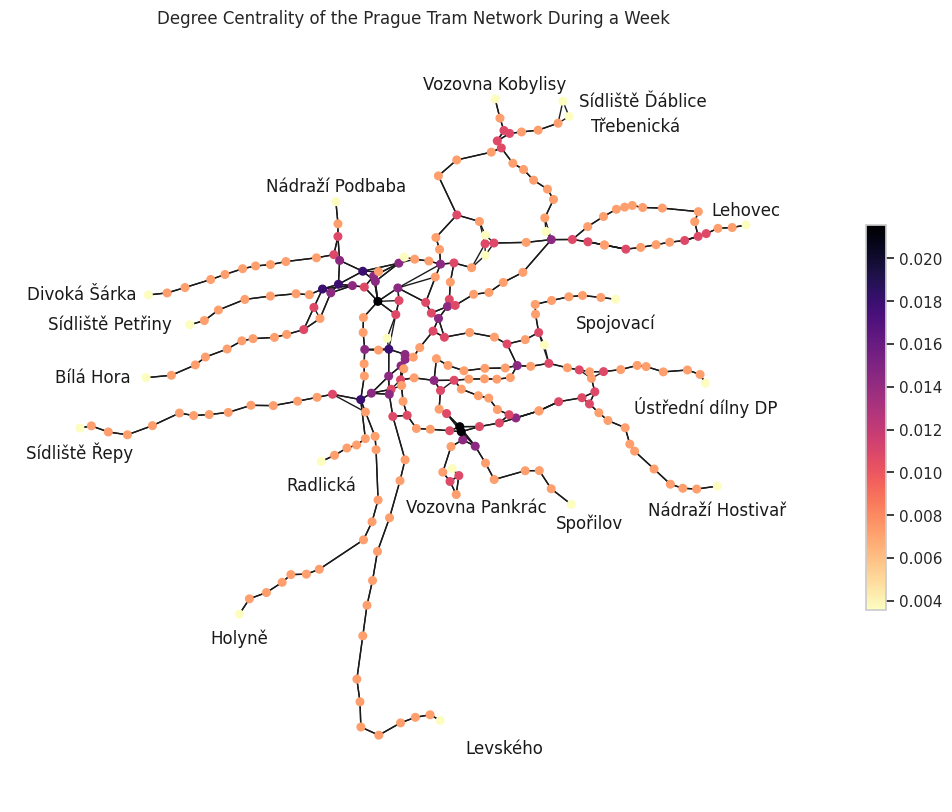

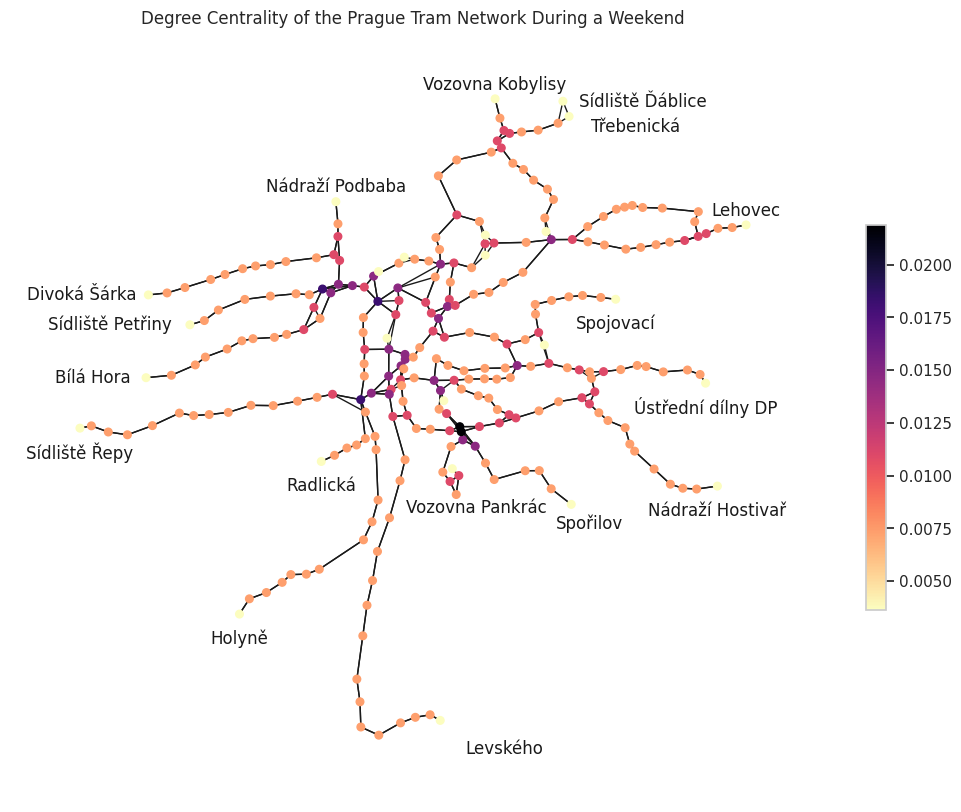

In [42]:
degree_centr_w = nx.out_degree_centrality(network_w)
degree_centr_wend = nx.out_degree_centrality(network_wend)

vis_centrality(network_w, degree_centr_w, 'Degree Centrality of the Prague Tram Network During a Week', '', labels, labels_pos, avg_stops_loc)
vis_centrality(network_wend, degree_centr_wend, 'Degree Centrality of the Prague Tram Network During a Weekend', '', labels, labels_pos, avg_stops_loc)

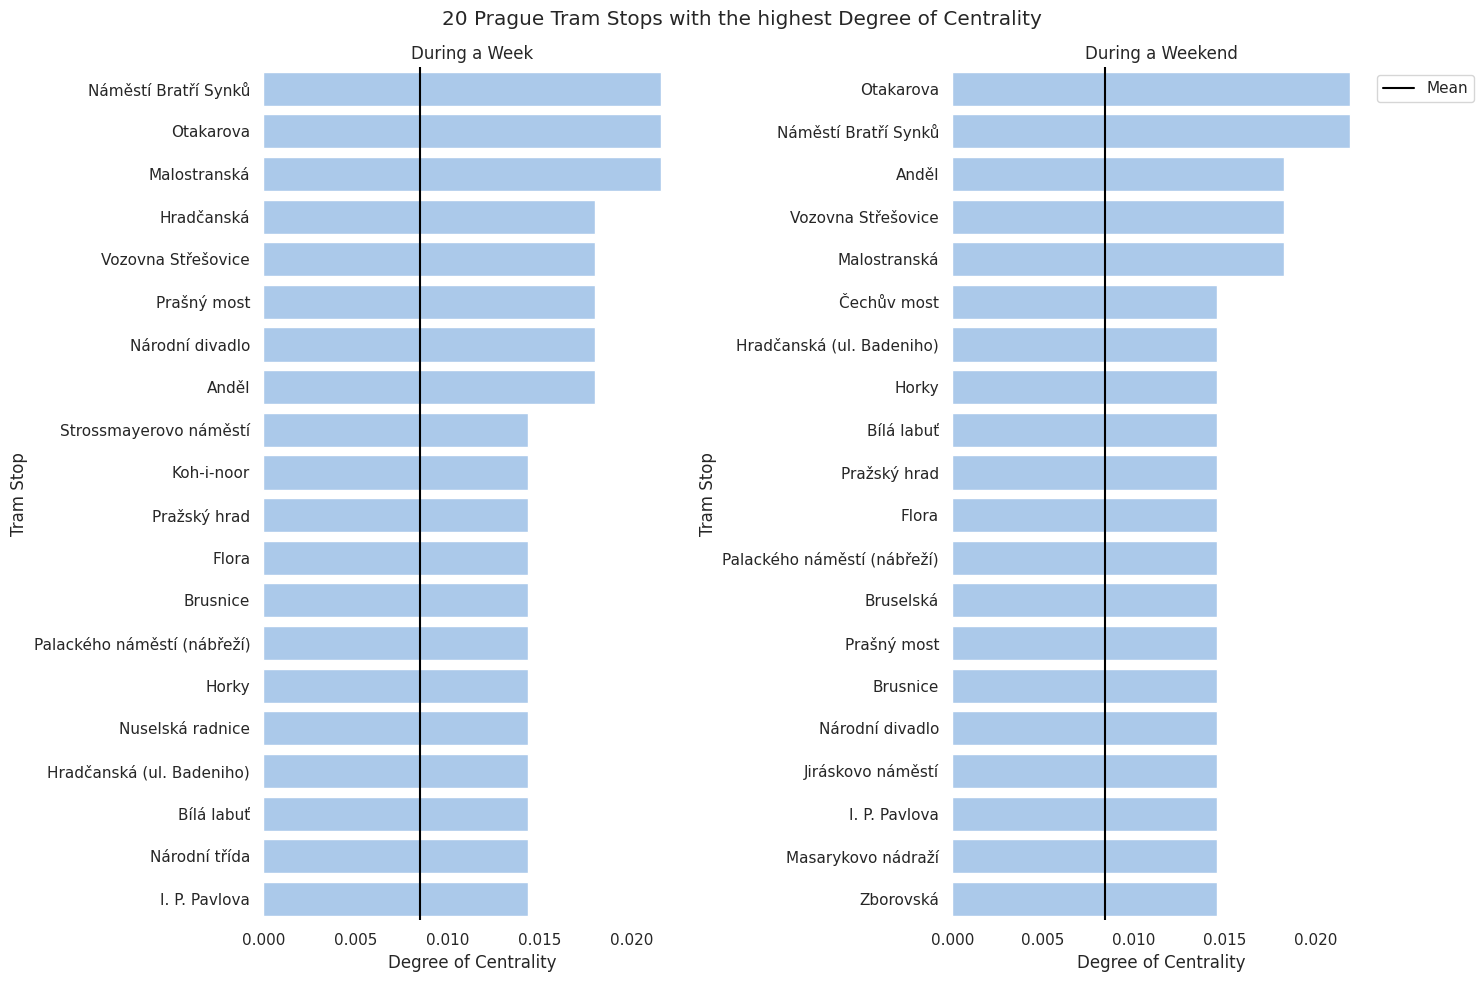

In [43]:
bar_centrality('Degree of Centrality', degree_centr_w, degree_centr_wend, 20)

Grafy v predchádzajúcich bunkách vizualizujú stupňovú centralitu pražskej električkovej sieťe počas pracovného týždňa a víkendu. Stupňová centralita určuje počet hrán vedúce do/z vrcholu, teda počet zastávok spojených s vrcholom. Počas týždňa má najvyššiu stupňovú centralitu ("authority") stanica Náměstí bratří synků. Počas víkendu stanica Otakarova. Z vizualizácie siete je možné pozorovať, že zastávky s vysokými hodnotami sa nachádzajú najmä v centre siete.

### Centralita Blízkosti

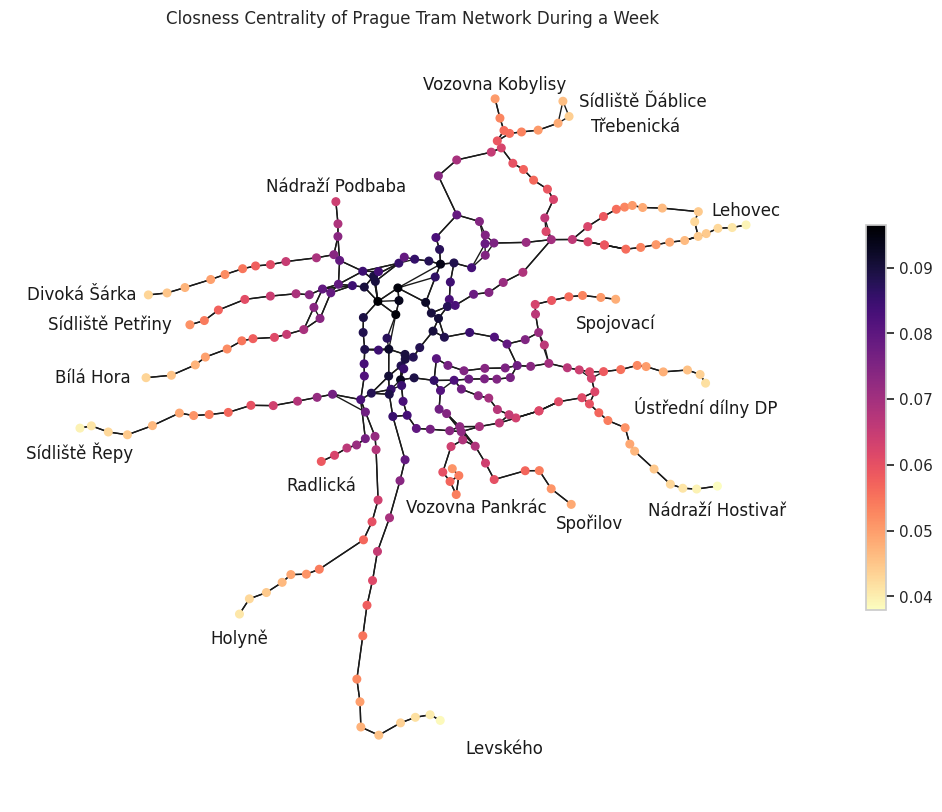

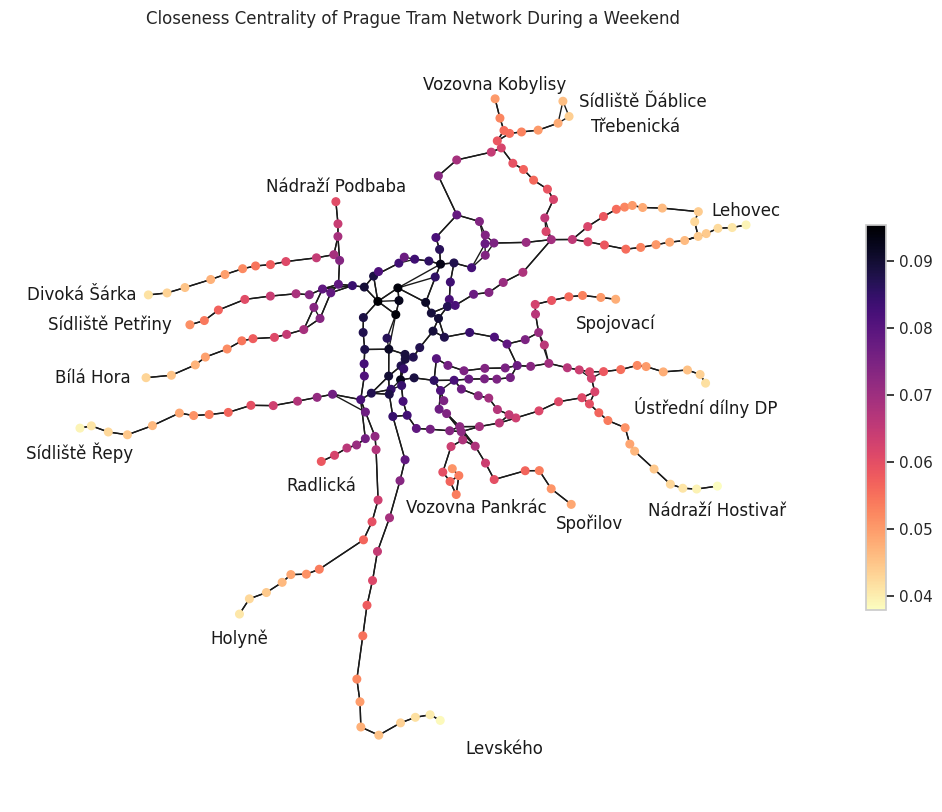

In [44]:
clossness_centr_w = nx.closeness_centrality(network_w)
clossness_centr_wend = nx.closeness_centrality(network_wend)

vis_centrality(network_w, clossness_centr_w, 'Closness Centrality of the Prague Tram Network During a Week', '', labels, labels_pos, avg_stops_loc)
vis_centrality(network_wend, clossness_centr_wend, 'Closeness Centrality of the  Prague Tram Network During a Weekend', '', labels, labels_pos, avg_stops_loc)

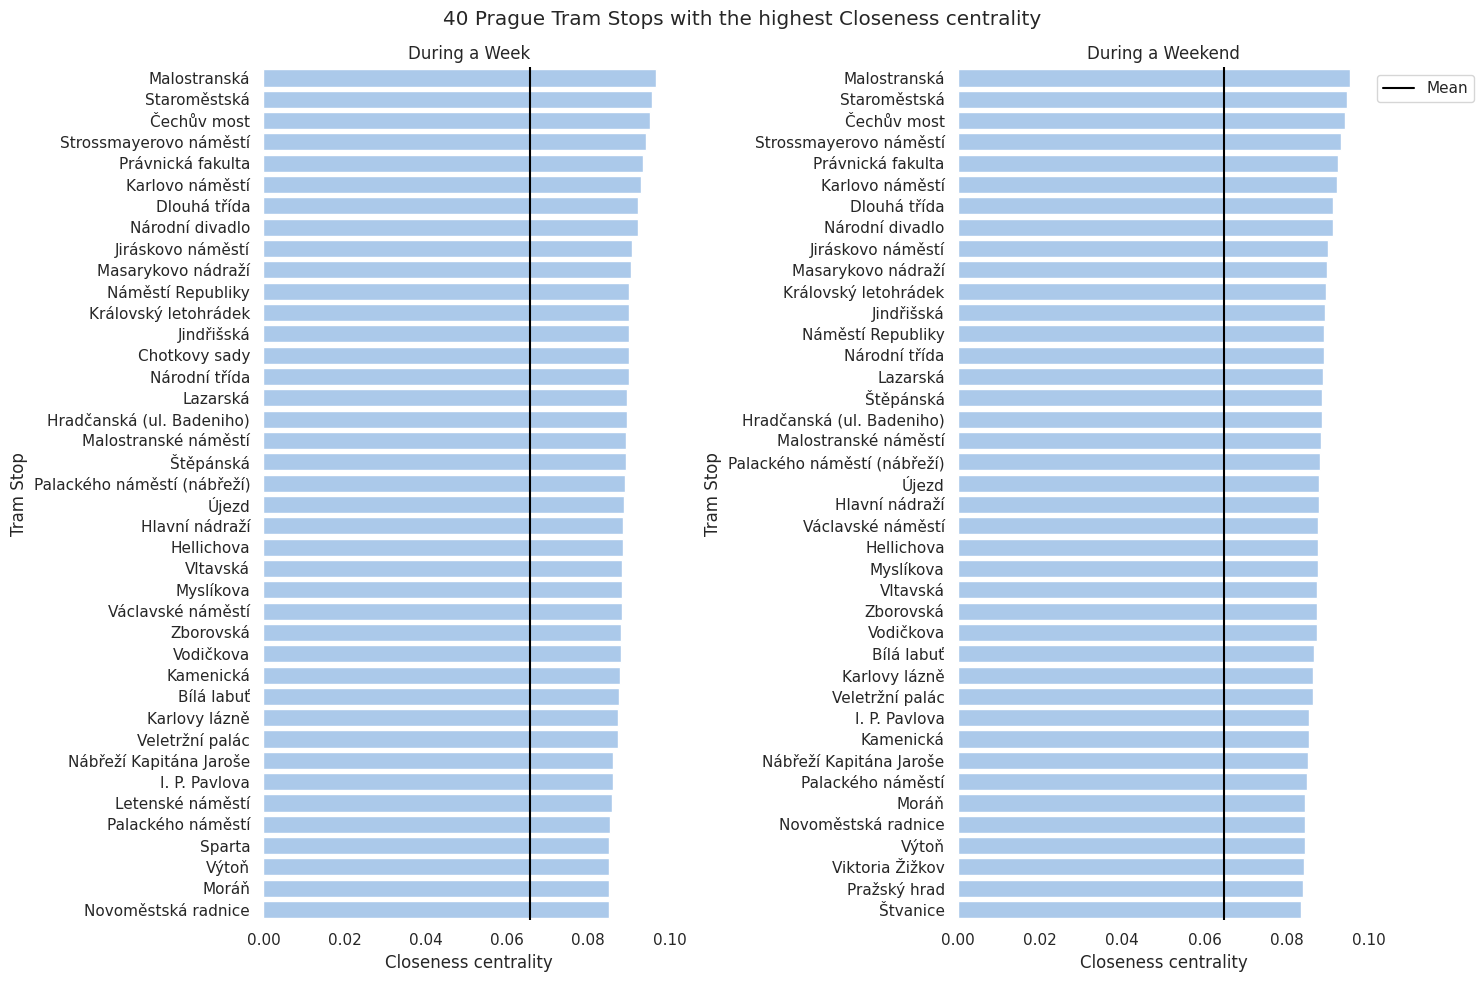

In [45]:
bar_centrality('Closeness centrality', clossness_centr_w, clossness_centr_wend, 40)

Centralita blízkosti analyzuje dôležitosť zastávok (vrcholov) vzhľadom k ich vzdialenosti od ďalších vrcholov. V prípade pražskej električkovej siete patria medzi najdôležitejšie (teda najbližšie k ostatným) zastávky: Malostranská, Staroměstská a Čechův most. Rozdiel v hodnote centralít počas víkendu a týždňa nájdeme až na 10. pozícii v stĺpcovom grafe. Počas víkendu ide o zastávku Královský letohrádek a počas týždňa Náměstí Republiky. 

### Centralita Medziľahlosti

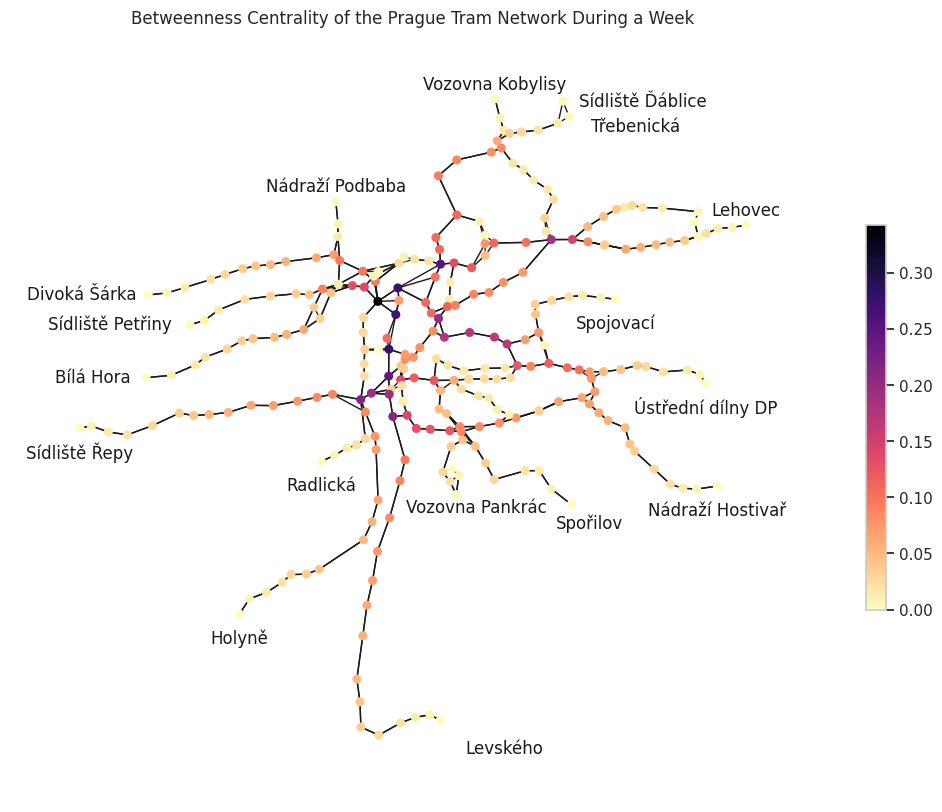

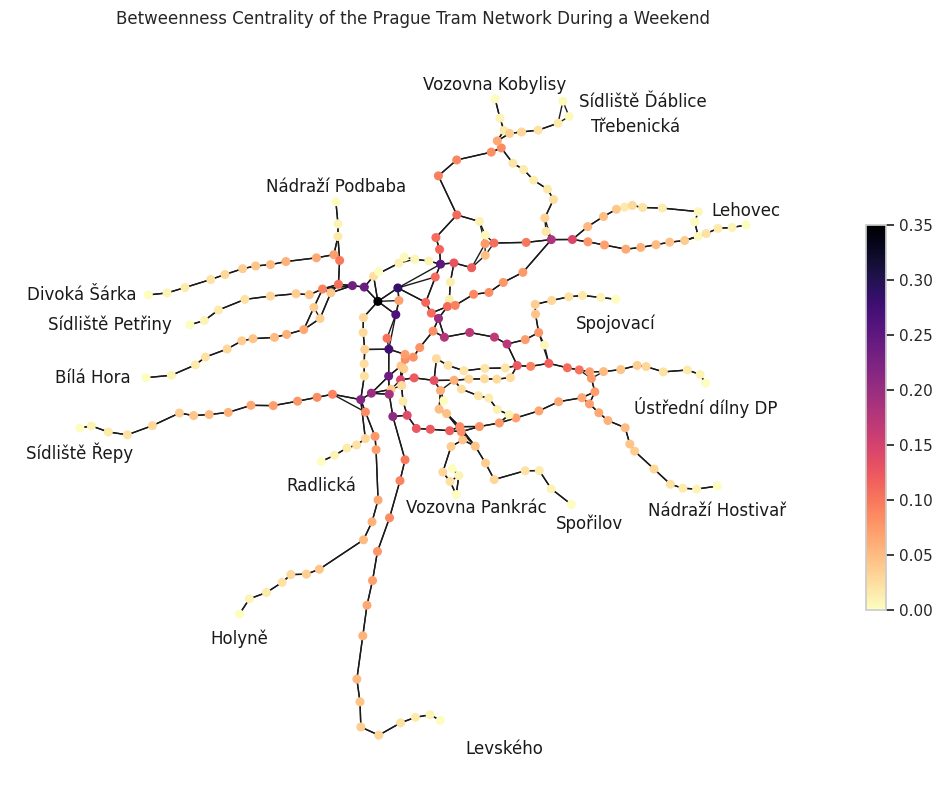

In [47]:
betweenness_centr_w = nx.betweenness_centrality(network_w)
betweenness_centr_wend = nx.betweenness_centrality(network_wend)

vis_centrality(network_w, betweenness_centr_w, 'Betweenness Centrality of the Prague Tram Network During a Week', '', labels, labels_pos, avg_stops_loc)
vis_centrality(network_wend, betweenness_centr_wend, 'Betweenness Centrality of the Prague Tram Network During a Weekend', '', labels, labels_pos, avg_stops_loc)

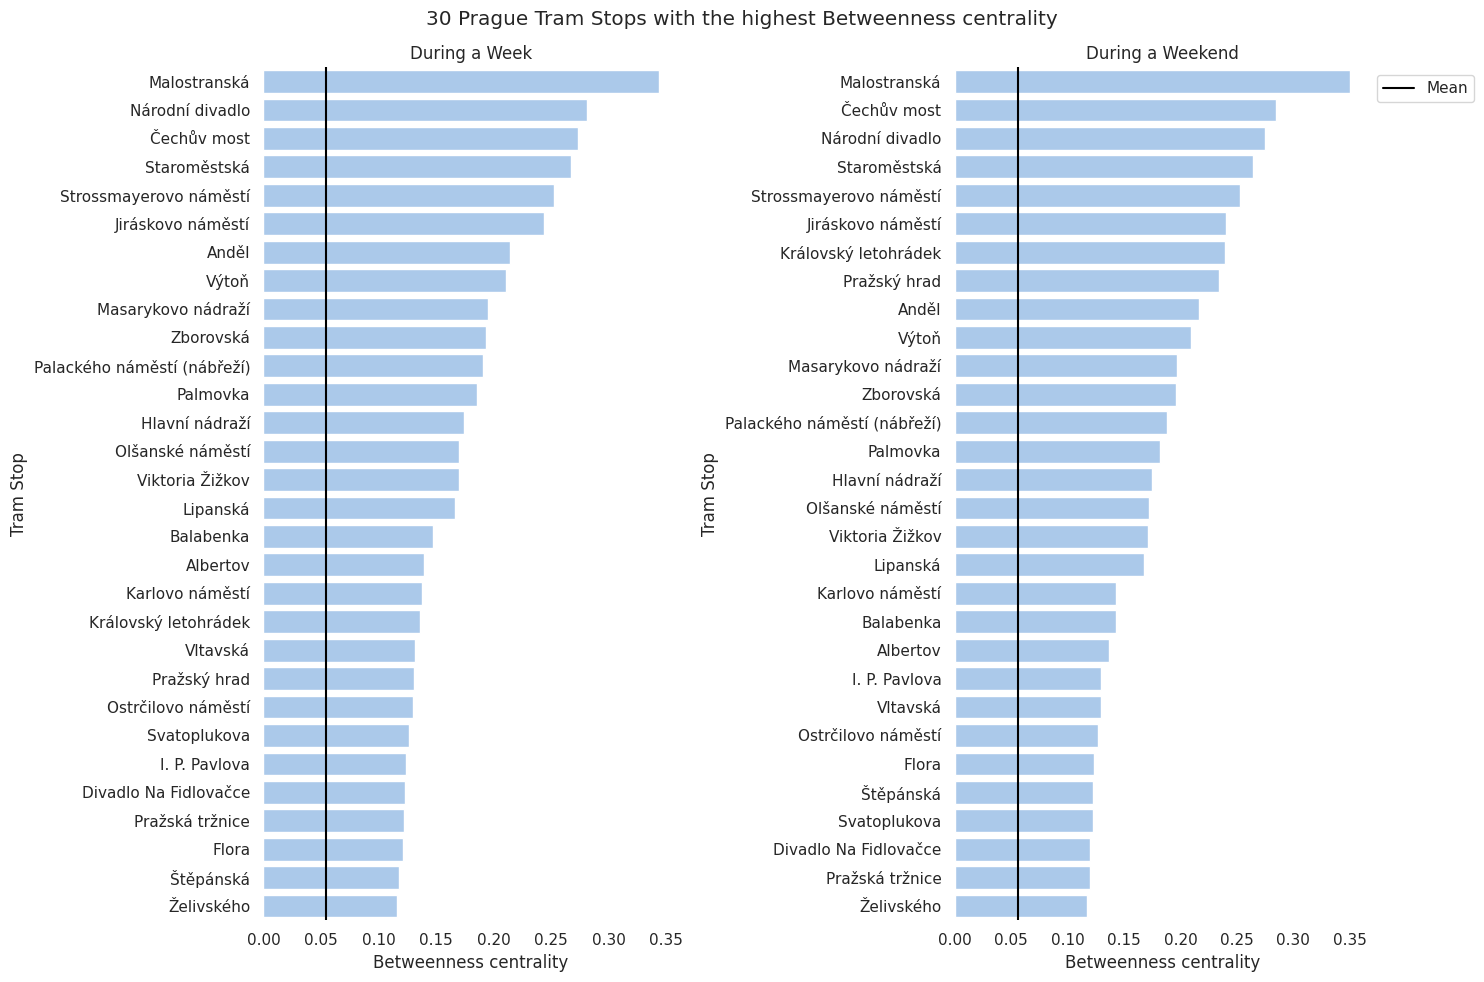

In [48]:
bar_centrality('Betweenness centrality', betweenness_centr_w, betweenness_centr_wend, 30)

Z predchádzajúcich grafov môžeme vypozorovať, že zastávky s najvyššou centralitou medziľahlosti sú Malostranská, Národní Divadlo, Staroměstská a Čechův most. Tieto zastávky sa objavujú na najkratšej ceste medzi zvyšnými zastávkami najčastejšie.

# Vlastné otázky

## 1. Aký je priemerný čas cesty medzi jednotlivými zastávkami?
Zaujímať nás bude priemerný čas jazdy električkou medzi zastávkami.
Odpoveď získame vizualizáciou rozloženia času pomocou krabicového grafu. Zároveň vizualizujeme električkovú sieť tak, že dĺžky ciest medzi zastávkami budeme reprezentovať sfarbením hrán.

Pred samotnou vizualizáciou je si potrebné upraviť dataset. Vytvoríme príznak, ktorý bude zachytávať čas cesty medzi zastávkami. Ten získame odčítaním príznakov `arrive_to` - `depart_from`. Výslednú hodnotu predelíme 60, čím získame požadovanú hodnotu v minutách.

In [30]:
import copy
tram_stops = pid[pid['route_type'] == route_type]
tram_stops = copy.deepcopy(tram_stops)

tram_stops['depart_from'] = pd.to_datetime(tram_stops['depart_from'], format='%H:%M:%S')
tram_stops['arrive_to'] = pd.to_datetime(tram_stops['arrive_to'], format='%H:%M:%S')

# Get time difference
tram_stops['diff'] = (tram_stops['arrive_to'] - tram_stops['depart_from'])
tram_stops['diff'] = (tram_stops['diff'].dt.seconds - (tram_stops['diff'].dt.seconds // 3600)) / 60

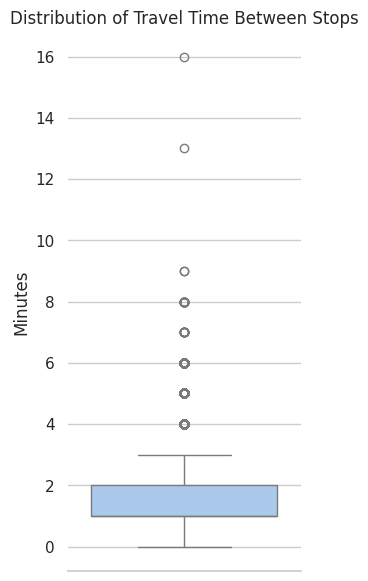

In [49]:
fig, ax = plt.subplots(figsize=(3,7))
sn.boxplot(tram_stops, y = 'diff', ax=ax)
ax.set_title('Distribution of Travel Time Between Stops')
ax.set_ylabel('Minutes')
sn.despine(fig, left=True)

In [32]:
# Create Graph with time between stops as weights
network_time = nx.DiGraph()
network_time.add_nodes_from(tram_stops['stop_to_name'].unique(), type='stop')
edges = list(tram_stops[['stop_from_name', 'stop_to_name', 'diff']].itertuples(index=False, name=None))
network_time.add_weighted_edges_from(edges)

In [33]:
edge_colors = [edge[2]['weight'] for edge in network_time.edges(data=True)]

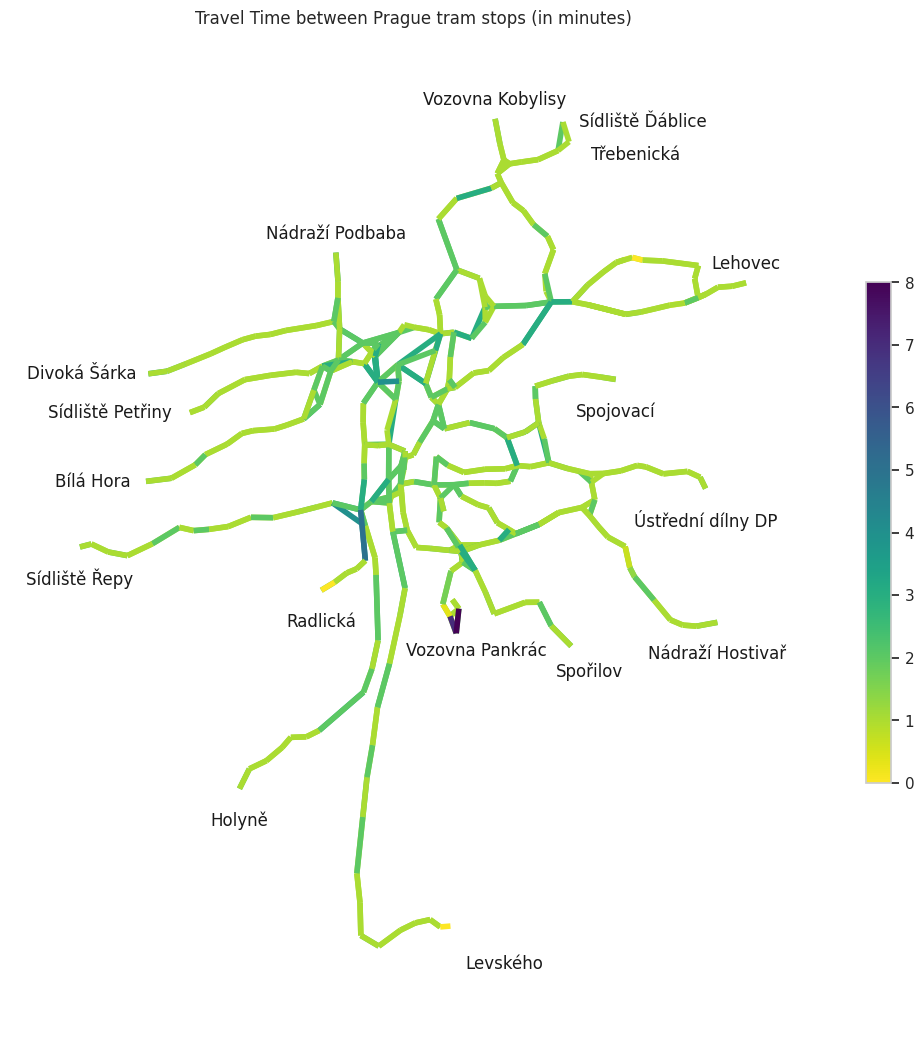

In [50]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.grid(False)
ax.set_title('Travel Time between Prague tram stops (in minutes)')
ax.spines[:].set_visible(False)

nx.draw_networkx_labels(network_time, labels = labels, pos=labels_pos, ax=ax)
nx.draw_networkx_edges(network_time, pos=avg_stops_loc,  ax=ax, arrows=False, edge_color=edge_colors, edge_cmap = plt.cm.viridis_r, width = 4)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
bar = plt.colorbar(sm, ax = ax, shrink=0.5)   


Cesta medzi väčšinou zastávok trvá 1 až 2 minúty. V prvom grafe je vidieť, že najdlhší čas cesty medzi zastávkami je 16 minút. Z vizualizácie siete je možné vypozorovať, že cesty trvajú dlhšie v centre siete a kratšie na ich okrajoch. 

## 2. Aké zastávky by pri dočasnom uzatvorení spôsobili nesúvislosť električkovej siete?
Zaujímať nás budú vrcholy, ktoré by po odpojení zvýšili počet súvislých komponent. Výsledok vizualizujeme pomocou električkovej siete, v ktorej zvýrazníme nájdené vrcholy. 

In [35]:
len([edges for edges in network_w.edges if (edges[1],edges[0]) not in network_w.edges])

50

Z predchádzajúcej bunky vidíme, že graf obsahuje jednosmerné spojenia, preto ho nemôžeme symetrizovať. Hľadané stanice preto nájdeme vlastnou funkciou. Keďže sieť neobsahuje veľké množstvo vrcholov môžeme otestovať každú stanicu samostatne.

In [36]:
def find_points(p_graph):
    """Identify articulation points in an oriented graph using a brute-force approach."""
    graph = p_graph.copy()
    points = []
    before = list(nx.strongly_connected_components(p_graph))
    nodes = p_graph.nodes
    # check nodes
    for node in nodes:
        graph.remove_node(node)
        # calculate a number of strongly connected components in a new graph
        after = list(nx.strongly_connected_components(graph)) 
        # check if the node is articulation point
        if len(after) > len(before):
            points.append(node)
        graph = p_graph.copy()
    return points
    
art_points = find_points(network_w)

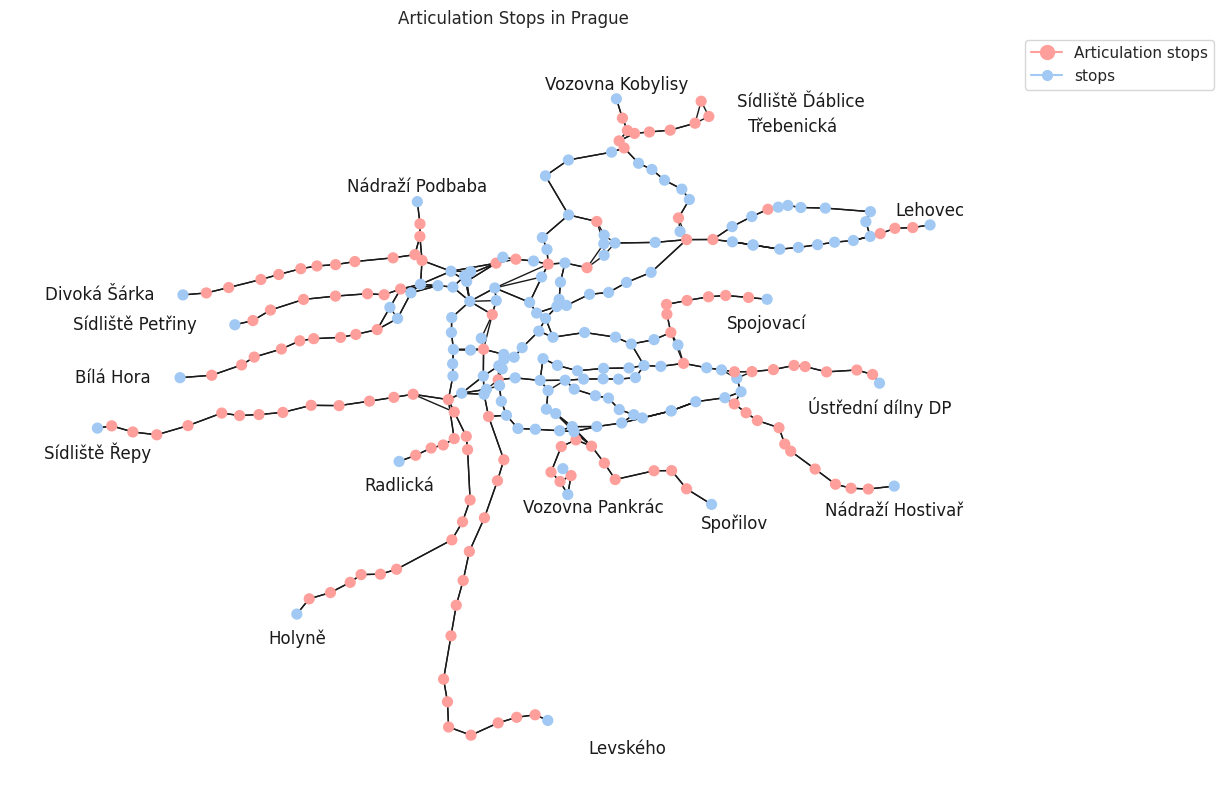

In [51]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.grid(False)
ax.set_title('Articulation Stops in Prague')
ax.spines[:].set_visible(False)

legend_labels = {'Articulation stops': ['r', 10], 'stops': ['b', 7]}
legend_handles = [plt.Line2D([0], [0], marker='o', color=data[0], markersize=data[1]) for label, data in legend_labels.items()]
ax.legend(legend_handles, legend_labels.keys(), loc='upper left', bbox_to_anchor=(1, 1))
nx.draw_networkx_labels(network_w, labels = labels, pos=labels_pos, ax=ax)
nx.draw_networkx_edges(network_w, pos=avg_stops_loc, ax=ax, arrows=False)
graph = nx.draw_networkx_nodes(network_w, pos=avg_stops_loc,node_size=50,ax=ax, node_color=['r' if node in art_points else 'b' for node in network_w])

Z grafu vypozorujeme, že takéto body sa nachádzajú na okrajoch siete, zatiaľ čo vrcholy v centre sieti sú navzájom poprepájanejšie. Výsledok sa zhoduje s vizualizáciou centrality blízkosti. 

## 3. Existujú cesty medzi zastávkami, ktoré by bolo možné zrušiť tak, aby žiadna zastávka nebola odpojená?
Hľadáme električkové spoje, teda hrany, ktoré by sme mohli z grafu odstrániť tak, aby sme nestratili spojenie so žiadnou zastávkou. Odpoveď by sme mohli získať nájdením kostry symetrizovaného grafu. Graf obsahuje jednosmerné cesty, preto budeme hľadať kostru podgrafu električkovej podsiete, ktorá obsahuje len obojsmerné cesty.

In [52]:
oneway_edges = ([edges for edges in network_w.edges if (edges[1],edges[0]) not in network_w.edges])

In [55]:
# Create tje subgraph
unoriented_newtork = network_w.copy()
unoriented_newtork.remove_edges_from(oneway_edges)
unoriented_newtork = unoriented_newtork.to_undirected(reciprocal=True)

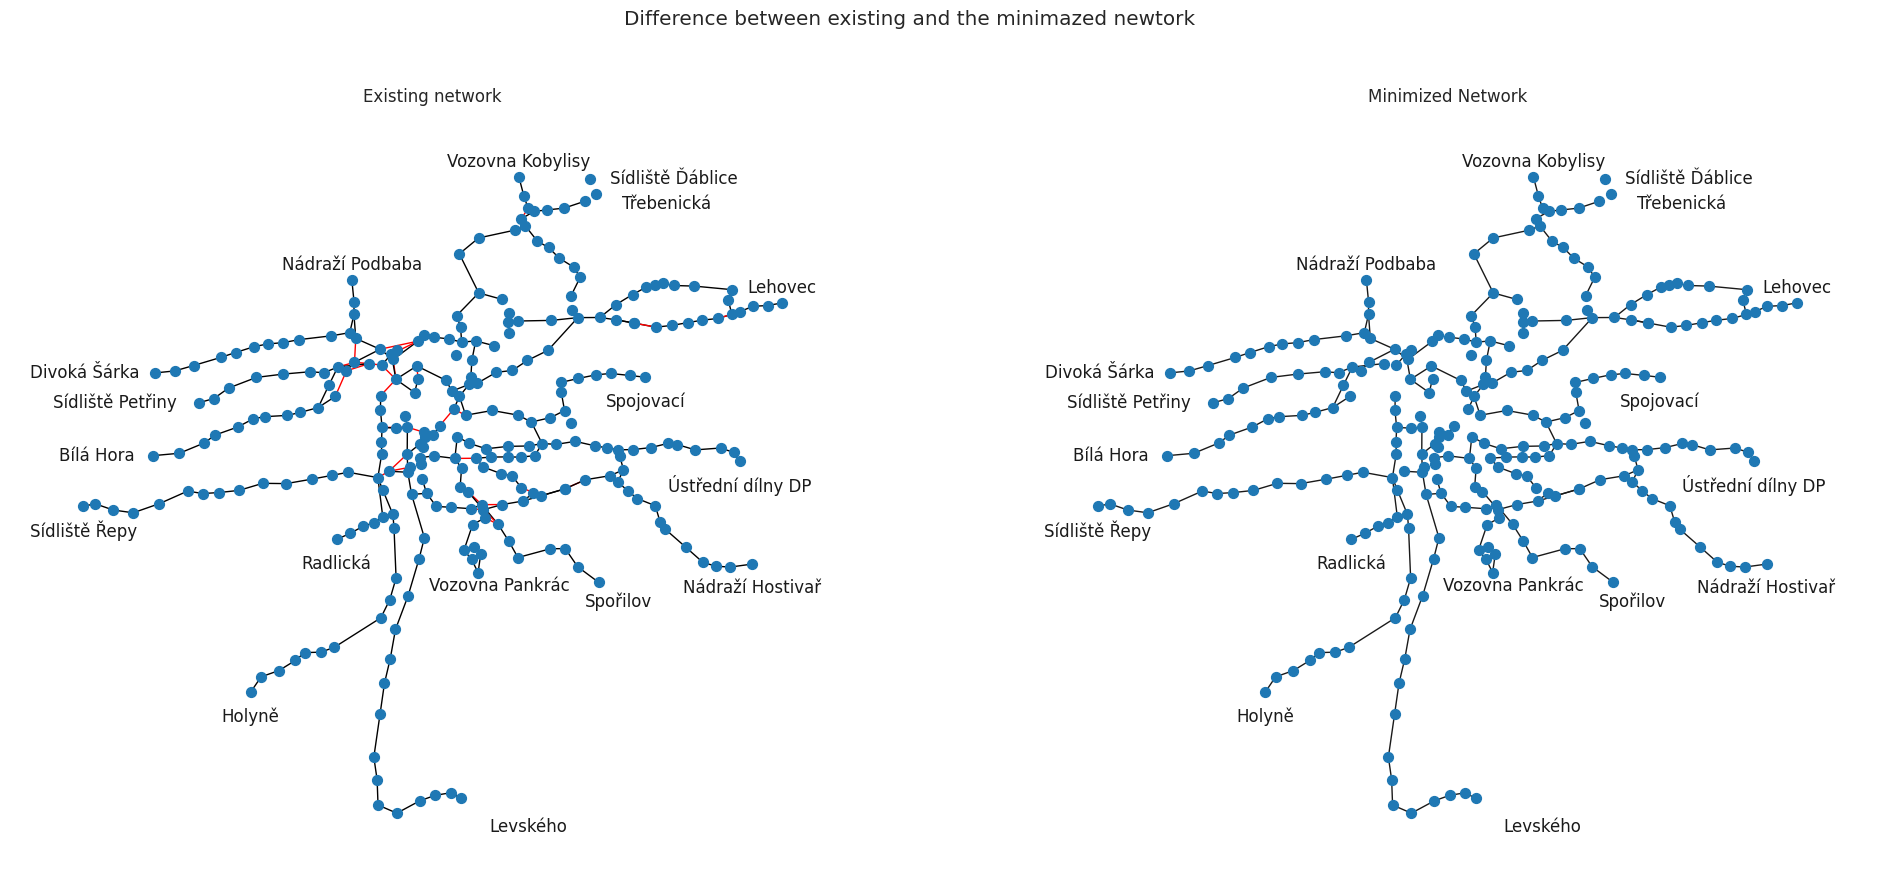

In [56]:
# Find tree
tree = nx.minimum_spanning_tree(unoriented_newtork)

fig, ax = plt.subplots(1,2, figsize=(24, 10))
fig.suptitle('Difference between existing and the minimazed newtork')
ax[0].set_title("Existing network")
ax[0].grid(False)
ax[0].spines[:].set_visible(False)

nx.draw_networkx_labels(unoriented_newtork, labels = labels, pos=labels_pos, ax=ax[0])
nx.draw_networkx_edges(unoriented_newtork, pos=avg_stops_loc, edge_color=['black' if edge in tree.edges else 'red' for edge in unoriented_newtork.edges],ax=ax[0], arrows=False)
graph = nx.draw_networkx_nodes(tree, pos=avg_stops_loc,node_size=50,ax=ax[0])

ax[1].grid(False)
ax[1].set_title('Minimized Network')
ax[1].spines[:].set_visible(False)

nx.draw_networkx_labels(tree, labels = labels, pos=labels_pos, ax=ax[1])
nx.draw_networkx_edges(tree, pos=avg_stops_loc, ax=ax[1])
graph = nx.draw_networkx_nodes(tree, pos=avg_stops_loc,node_size=50, ax=ax[1])

Z grafu môžeme vypozorovať, že takéto spoje sa nachádzajú hlavne v centre električkovej sieti. 